In [ ]:
# Import library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [ ]:
#Device configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = True if torch.cuda.is_available() else False
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Hyperparmeter

In [ ]:
# -----------------------------
# 2️⃣ Reproducibility
# -----------------------------
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# -----------------------------
# 3️⃣ Hyperparameters
# -----------------------------
EPOCHS = 10
LR = 0.0005
BATCH_SIZE = 4

In [ ]:
# Data preprocess

In [ ]:

transform_lenet = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_alexnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Data loader

In [ ]:
# 5️⃣ Load CIFAR-10 dataset (subset for speed)
# -----------------------------
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# Use a larger subset to help AlexNet generalize
train_subset_idx = list(range(2000))
test_subset_idx = list(range(200))

train_dataset_lenet = Subset(torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_lenet), train_subset_idx)
test_dataset_lenet = Subset(torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_lenet), test_subset_idx)

train_dataset_alex = Subset(torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_alexnet), train_subset_idx)
test_dataset_alex = Subset(torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_alexnet), test_subset_idx)

train_loader_lenet = DataLoader(train_dataset_lenet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=pin_memory)
test_loader_lenet = DataLoader(test_dataset_lenet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_memory)
train_loader_alex = DataLoader(train_dataset_alex, batch_size=BATCH_SIZE, shuffle=True, pin_memory=pin_memory)
test_loader_alex = DataLoader(test_dataset_alex, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_memory)


In [ ]:
# Visualization

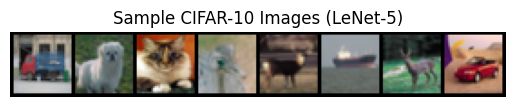

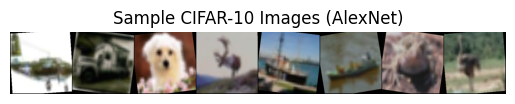

In [ ]:
import torchvision

def imshow(imgs, title=None):
    """
    Display a batch of images (grayscale or RGB) after denormalization.
    """
    imgs = imgs.cpu()  # ensure images are on CPU
    # Denormalize (handles both 1-channel and 3-channel images)
    if imgs.shape[1] == 1:
        imgs = imgs * 0.5 + 0.5  # grayscale
        npimgs = imgs.numpy().squeeze(1)  # remove channel dimension
        grid_img = torchvision.utils.make_grid(torch.tensor(npimgs))
        plt.imshow(grid_img.numpy(), cmap='gray')
    else:
        imgs = imgs * 0.5 + 0.5  # RGB
        grid_img = torchvision.utils.make_grid(imgs)
        npimgs = grid_img.numpy()
        npimgs = np.transpose(npimgs, (1, 2, 0))
        plt.imshow(npimgs)

    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Example usage:

# For LeNet-5
dataiter = iter(train_loader_lenet)
images, labels = next(dataiter)
imshow(images[:8], title="Sample CIFAR-10 Images (LeNet-5)")

# For AlexNet
dataiter = iter(train_loader_alex)
images, labels = next(dataiter)
imshow(images[:8], title="Sample CIFAR-10 Images (AlexNet)")


In [ ]:
# Define Model Architects

In [ ]:

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# AlexNet (simplified, pretrained backbone)
from torchvision.models import alexnet
class AlexNetFineTune(nn.Module):
    def __init__(self, pretrained=True):
        super(AlexNetFineTune, self).__init__()
        self.model = alexnet(pretrained=pretrained)
        # freeze earlier layers to reduce overfitting
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier[6] = nn.Linear(4096, 10)

    def forward(self, x):
        return self.model(x)


In [ ]:
# Train and evaluate


Training LeNet-5...
Epoch 1/10 -> Loss: 2.1198, Acc: 22.65%, Time: 1.34s
Epoch 2/10 -> Loss: 1.9348, Acc: 30.50%, Time: 1.32s
Epoch 3/10 -> Loss: 1.8540, Acc: 35.10%, Time: 1.35s
Epoch 4/10 -> Loss: 1.7834, Acc: 37.45%, Time: 1.34s
Epoch 5/10 -> Loss: 1.7416, Acc: 38.35%, Time: 1.32s
Epoch 6/10 -> Loss: 1.7103, Acc: 39.85%, Time: 1.80s
Epoch 7/10 -> Loss: 1.6737, Acc: 41.45%, Time: 1.81s
Epoch 8/10 -> Loss: 1.6456, Acc: 42.60%, Time: 1.34s
Epoch 9/10 -> Loss: 1.6304, Acc: 43.40%, Time: 1.35s
Epoch 10/10 -> Loss: 1.6011, Acc: 43.30%, Time: 1.33s

Training AlexNet (fine-tuned)...
Epoch 1/10 -> Loss: 1.5685, Acc: 44.05%, Time: 138.37s
Epoch 2/10 -> Loss: 1.1484, Acc: 59.30%, Time: 133.52s
Epoch 3/10 -> Loss: 1.0026, Acc: 63.25%, Time: 132.57s
Epoch 4/10 -> Loss: 0.9250, Acc: 66.75%, Time: 139.47s
Epoch 5/10 -> Loss: 0.8576, Acc: 70.15%, Time: 140.88s
Epoch 6/10 -> Loss: 0.7895, Acc: 72.25%, Time: 133.89s
Epoch 7/10 -> Loss: 0.7460, Acc: 74.45%, Time: 133.65s
Epoch 8/10 -> Loss: 0.7306, A

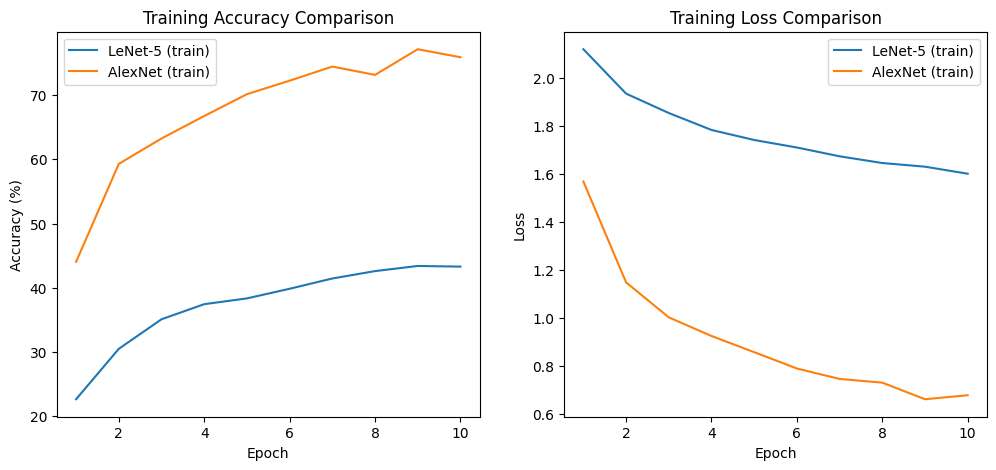

In [ ]:

def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    epoch_losses, epoch_accs = [], []

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / total
        acc = 100 * correct / total
        epoch_losses.append(avg_loss)
        epoch_accs.append(acc)
        print(f"Epoch {epoch+1}/{epochs} -> Loss: {avg_loss:.4f}, Acc: {acc:.2f}%, Time: {time.time()-start_time:.2f}s")

    return epoch_losses, epoch_accs

# -----------------------------
# 8️⃣ Evaluation function
# -----------------------------
def evaluate(model, test_loader):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc

# -----------------------------
# 9️⃣ Main execution
# -----------------------------
if __name__ == "__main__":
    lenet_model = LeNet5().to(device)
    alex_model = AlexNetFineTune(pretrained=True).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer_lenet = optim.Adam(lenet_model.parameters(), lr=LR, weight_decay=1e-4)
    optimizer_alex = optim.Adam(filter(lambda p: p.requires_grad, alex_model.parameters()), lr=LR)

    print("\nTraining LeNet-5...")
    lenet_losses, lenet_accs = train(lenet_model, train_loader_lenet, criterion, optimizer_lenet, epochs=EPOCHS)

    print("\nTraining AlexNet (fine-tuned)...")
    alex_losses, alex_accs = train(alex_model, train_loader_alex, criterion, optimizer_alex, epochs=EPOCHS)

    lenet_test_loss, lenet_test_acc = evaluate(lenet_model, test_loader_lenet)
    alex_test_loss, alex_test_acc = evaluate(alex_model, test_loader_alex)

    print(f"\n✅ LeNet-5 Test -> Loss: {lenet_test_loss:.4f}, Acc: {lenet_test_acc:.2f}%")
    print(f"✅ AlexNet Test -> Loss: {alex_test_loss:.4f}, Acc: {alex_test_acc:.2f}%")

    # -----------------------------
    # Plot comparison
    # -----------------------------
    epochs_range = list(range(1, EPOCHS+1))
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, lenet_accs, label='LeNet-5 (train)')
    plt.plot(epochs_range, alex_accs, label='AlexNet (train)')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Comparison")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, lenet_losses, label='LeNet-5 (train)')
    plt.plot(epochs_range, alex_losses, label='AlexNet (train)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.show()

In [ ]:
# Here is a comparison graph of alexnet with out pretrained with leNet - tried on another code

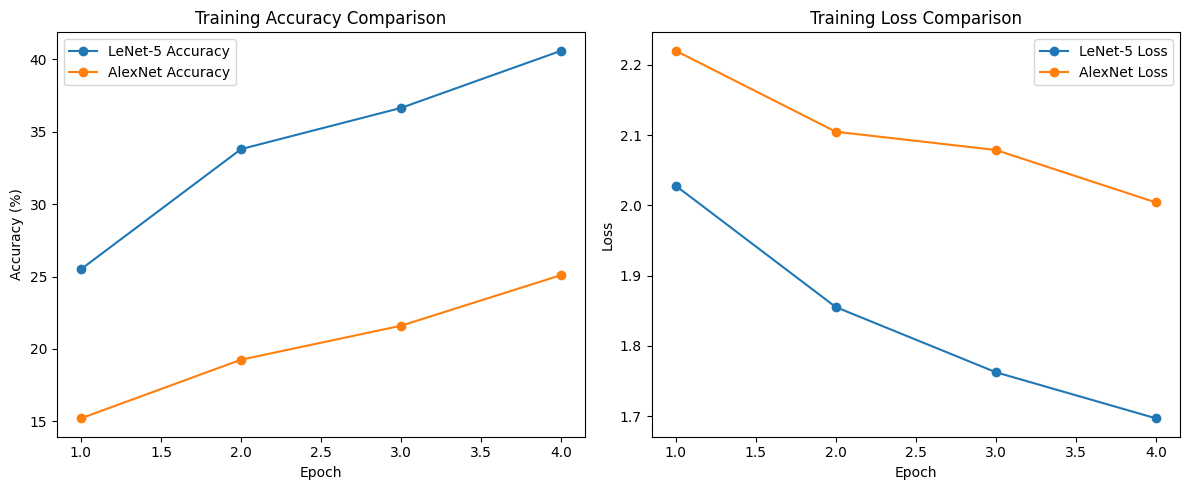

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3, 4]

# LeNet-5 metrics
lenet_loss = [2.0281, 1.8553, 1.7625, 1.6969]
lenet_acc = [25.50, 33.80, 36.65, 40.60]

# AlexNet (from scratch) metrics
alex_loss = [2.2202, 2.1049, 2.0789, 2.0042]
alex_acc = [15.20, 19.25, 21.60, 25.10]

# Plot Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, lenet_acc, marker='o', label='LeNet-5 Accuracy')
plt.plot(epochs, alex_acc, marker='o', label='AlexNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, lenet_loss, marker='o', label='LeNet-5 Loss')
plt.plot(epochs, alex_loss, marker='o', label='AlexNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()
